# QNLP example
This notebook runs an example encoding of **"John rests inside, Mary walks outside"**. We initially define mappings for each of these tokens to a pre-defined set of basis tokens. These tokens are next represented as binary integers, and encoded using the QNLP runtime.

A test pattern is then constructed using **"adults stand inside"**, and the encoded patterns are queried and sampled to determine the closest encoded data, as learned from the given sentences.


The basis tokens are defined as:

$$
\begin{equation*}
\begin{array}{c|c|c}
\mathbf{Dataset} & \mathbf{Word} & \mathbf{Bin.~Index} \\
\hline
{n_s} & \mathrm{adult} & 00 \\
{n_s} & \mathrm{child} & 01 \\
{n_s} & \mathrm{smith} & 10 \\
{n_s} & \mathrm{surgeon} & 11 \\
\\
{v} & \mathrm{stand} & 00 \\
{v} & \mathrm{move} & 01 \\
{v} & \mathrm{sit} & 10 \\
{v} & \mathrm{sleep} & 11 \\
\\
{n_o} & \mathrm{inside} & 0 \\
{n_o} & \mathrm{outside} & 1 \\
\end{array}
\end{equation*}
$$

We define the mapping of *"John rests inside, Mary walks outside"* to this basis as:

$$
\begin{equation*}
\begin{array}{c|c|c}
\mathbf{Dataset} & \mathbf{Word} & \mathbf{State} \\
\hline
{n_s} & \mathrm{John} & (\vert 00 \rangle + \vert 10 \rangle)/\sqrt{2} \\
{n_s} & \mathrm{Mary} & (\vert 01 \rangle + \vert 11 \rangle)/\sqrt{2} \\
{v} & \mathrm{walk} & (\vert 00 \rangle + \vert 01 \rangle)/\sqrt{2} \\
{v} & \mathrm{rest} & (\vert 10 \rangle + \vert 11 \rangle)/\sqrt{2} \\
{n_o} & \mathrm{inside} & \vert 0 \rangle  \\
{n_o} & \mathrm{outside} & \vert 1 \rangle  \\
\end{array}
\end{equation*}
$$

Lastly, our test pattern is mapped onto the basis as **"adults stand inside"** $\rightarrow |00000\rangle$. The remainder of the notebook will encode the data using the given basis, encode the test pattern, and query the resulting register state using the Hamming distance to determine closeness.

In [1]:
%matplotlib notebook
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt

Import the C++ backed simulator package and the preprocessing Python package

In [2]:
from PyQNLPSimulator import PyQNLPSimulator as p
import QNLP as q
import numpy as np
from itertools import product

Predefine necessary data for encoding and calculate resources requirements

In [3]:
# Define basis tokens encoding and decoding dicts
encoding_dict = {"ns" : { "adult":0, "child":1, "smith":2, "surgeon":3 },
                 "v"  : { "stand":0, "move":1, "sit":2, "sleep":3 },
                 "no" : { "inside":0,"outside":1 }
                }

decoding_dict = {"ns" : { 0:"adult", 1:"child", 2:"smith", 3:"surgeon"},
                 "v"  : { 0:"stand", 1:"move", 2:"sit", 3:"sleep"},
                 "no" : { 0:"inside", 1:"outside"}
                }

In [4]:
len_reg_memory = 5
len_reg_ancilla = len_reg_memory + 2
num_qubits = len_reg_memory + len_reg_ancilla
num_bin_pattern = 8

test_pattern = 0

Create simulator object

In [5]:
use_fusion = False
sim = p(num_qubits, use_fusion)
num_exps = 20000
normalise = True

In [6]:
# Set up registers to store indices
reg_memory = [0]*len_reg_memory;
for i in range(len_reg_memory):
    reg_memory[i] = i

reg_ancilla = [0]*len_reg_ancilla
for i in range(len_reg_ancilla):
    reg_ancilla[i] = i + len_reg_memory;

In [7]:
# data for encoding using the given basis
"John rests outside, Mary walks inside"
sentences = [
    [{"john" :   [encoding_dict["ns"]["adult"], encoding_dict["ns"]["smith"]]},
    {"rest" :    [encoding_dict["v"]["sit"], encoding_dict["v"]["sleep"]]},
    {"inside" :  [encoding_dict["no"]["inside"]] }],

    [{"mary" :   [encoding_dict["ns"]["child"], encoding_dict["ns"]["surgeon"]]},
    {"walk" :    [encoding_dict["v"]["stand"],  encoding_dict["v"]["move"]]},
    {"outside" :[encoding_dict["no"]["outside"]] }],
]
sentences

[[{'john': [0, 2]}, {'rest': [2, 3]}, {'inside': [0]}],
 [{'mary': [1, 3]}, {'walk': [0, 1]}, {'outside': [1]}]]

In [8]:
# Create shift patterns for the encoding step
bit_shifts = [i[1] for i in q.utils.get_type_offsets(encoding_dict)]
bit_shifts.reverse()

bit_shifts.insert(0,0)
bit_shifts = np.cumsum(bit_shifts)

# Parse the sentences and generate the required bit-patterns
superpos_patterns = [list(sentences[0][i].values())[0] for i in range(3)]

#Create list for the patterns to be encoded
vec_to_encode = []

# Generate bit-patterns from sentences and store in vec_to_encode
for idx in range(len(sentences)):
    superpos_patterns = [list(sentences[idx][i].values())[0] for i in range(3)]
    # Generate all combinations of the bit-patterns for superpos states
    for i in list(product(superpos_patterns[2], superpos_patterns[1], superpos_patterns[0])):
        num = 0
        for val in zip(i,bit_shifts):
            num += (val[0] << val[1])
        vec_to_encode.extend([num])
        
vec_to_encode

[4, 20, 6, 22, 9, 25, 11, 27]

In [9]:
# Init result counter
count_even = {}
for i in vec_to_encode:
    count_even.update({i : 0})

In [10]:
# Test of equally encoded bit patterns
for exp in range(num_exps):

    sim.initRegister()

    # Encode
    sim.encodeBinToSuperpos_unique(reg_memory, reg_ancilla, vec_to_encode, len_reg_memory)
    
    val = sim.applyMeasurementToRegister(reg_memory, normalise)
    count_even[val] += 1;


In [12]:
# Test value to compare
val = 0; # 00000 ->  adult, stand, inside

# Init result counter
count = {}
for i in vec_to_encode:
    count.update({i : 0})

In [13]:
# Repeated shots of experiment
for exp in range(num_exps):

    sim.initRegister()

    # Encode
    sim.encodeBinToSuperpos_unique(reg_memory, reg_ancilla, vec_to_encode, len_reg_memory)

    # Compute Hamming distance between test pattern and encoded patterns
    sim.applyHammingDistanceRotY(test_pattern, reg_memory, reg_ancilla, len_reg_memory, num_bin_pattern)

    # Measure
    sim.collapseToBasisZ(reg_ancilla[len_reg_ancilla-2], 1)
    
    val = sim.applyMeasurementToRegister(reg_memory, normalise)
    count[val] += 1;


In [23]:
xlab_bin = ["{0:0{num_bits}b}".format(i, num_bits=len_reg_memory) for i in list(count.keys())]

{4: 2451, 20: 2549, 6: 2550, 22: 2469, 9: 2506, 25: 2494, 11: 2490, 27: 2491}

In [14]:
xlab_str = [",".join(q.utils.bin_to_sentence(i, encoding_dict, decoding_dict))  for i in list(count.keys())]
xlab_bin = ["{0:0{num_bits}b}".format(i, num_bits=len_reg_memory) for i in list(count.keys())]
[i[0]+"\n"+i[1] for i in zip(xlab_str,xlab_bin)]
# Sort histograms by P
hist_list = zip(
    [i[0]+r" $\vert$"+i[1]+r"$\rangle$" for i in zip(xlab_str,xlab_bin)],
    [i/num_exps for i in list(count.values())]
)
hist_list = sorted(hist_list, key=lambda pr: pr[1], reverse=True)

In [33]:
xlab_str = [",".join(q.utils.bin_to_sentence(i, encoding_dict, decoding_dict))  for i in list(count.keys())]
xlab_bin = ["{0:0{num_bits}b}".format(i, num_bits=len_reg_memory) for i in list(count.keys())]
[i[0]+"\n"+i[1] for i in zip(xlab_str,xlab_bin)]

# Sort histograms by P
hist_list_even = list(zip(
    [i[0]+r" $\vert$"+i[1]+r"$\rangle$" for i in zip(xlab_str,xlab_bin)],
    [i/np.sum(list(count_even.values())) for i in list(count_even.values())]
))
hist_list = list(zip(
    [i[0]+r" $\vert$"+i[1]+r"$\rangle$" for i in zip(xlab_str,xlab_bin)],
    [i/np.sum(list(count.values())) for i in list(count.values())]
))
#hist_list = sorted(hist_list, key=lambda pr: pr[1], reverse=True)

<IPython.core.display.Javascript object>


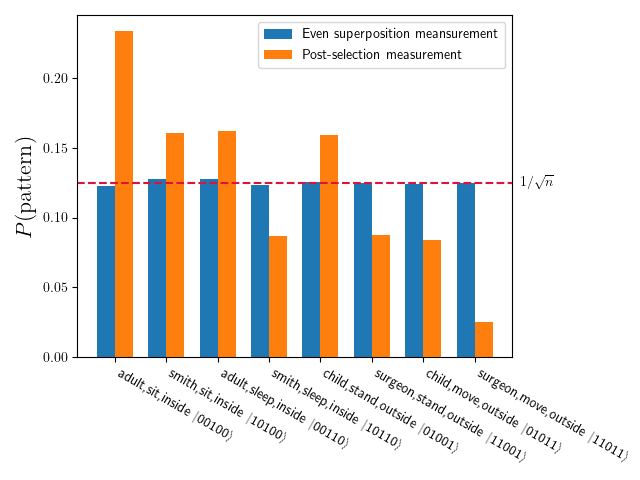

In [47]:
labels = [x[0] for x in hist_list_even]
even_vals = [y[1] for y in hist_list_even]
post_vals = [y[1] for y in hist_list]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, even_vals, width, label='Even superposition meansurement')
rects2 = ax.bar(x + width/2, post_vals, width, label='Post-selection measurement')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r"$P(\textrm{pattern})$",fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=-30, ha="left")
ax.legend()

plt.axhline(y=1.0/len(count), color='crimson', linestyle="--")
plt.text(len(count)-0.1, 1.0/(len(count)), '$1/\sqrt{n}$', horizontalalignment='left', verticalalignment='center')

plt.tight_layout()

In [48]:
plt.savefig("qnlp_vector_measurement.pdf")

As we can see, the closest discovered pattern using the given basis is "adult, sit, inside". 